**As importações foram feitas conforme o andamento do projeto e agrupadas aqui**

In [2]:
#importações
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import Row as row
from pyspark.sql import SQLContext
import pandas as pd

In [4]:
spark = SparkSession.builder.config('spark.sql.repl.eagerEval.enabled',True).appName('covidBr').getOrCreate()

Enviando os arquivos para o HDFS
```shell
sudo cp -r /home/silas/Downloads/covid_atual/ /home/silas/Downloads/Spark/docker-bigdata/input/

hdfs dfs -put /input/covid_atual /user/silas/covid/
```


**Criando tabela HIVE RAW**
```shell
create table raw_covid_atual (
regiao string,
estado string, 
municipio string, 
coduf int, 
codmun int,
codRegiaoSaude int,
nomeRegiaoSaude string,
data int,
semanaEpi int,
populacaoTCU2019 int,
casosAcumulados int,
casosNovos int,
obitosAcumulado int,
obitosNovos int,
recuperadosNovos int,
emAcompanhamentoNovos int,
interior_metropolitana int )
row format delimited fields terminated by";"
lines terminated by "\n"
stored as textfile
tblproperties("skip.header.line.count"="1");

load data inpath "/user/silas/covid_new/" overwrite into table raw_covid_atual;
```


**Criando tabela particionada**

```shell
create table silver_covid_br (regiao string, estado string, coduf int, codmun int,codRegiaoSaude int, nomeRegiaoSaude string, data int, semanaEpi int, populacaoTCU2019 int, casosAcumulados int, casosNovos int, obitosAcumulado int, obitosNovos int, recuperadosNovos int, emAcompanhamentoNovos int, interior_metropolitana int ) partitioned by (municipio string) row format delimited fields terminated by";" lines terminated by "\n" stored as textfile tblproperties("skip.header.line.count"="1");

SET hive.exec.dynamic.partition = true;

SET hive.exec.dynamic.partition.mode = nonstrict;

insert overwrite table silver_covid_br partition(municipio) select * from raw_covid_atual ;
```

**Criacao do schema para leitura do csv**

In [3]:

schema_covidBr = StructType([
    StructField("regiao", StringType()),
    StructField("estado", StringType()),
    StructField("municipio", StringType()),
    StructField("coduf", IntegerType()),
    StructField("codmun", IntegerType()),
    StructField("codRegiaoSaude", IntegerType()),
    StructField("nomeRegiaoSaude", StringType()),
    StructField("data", TimestampType()),
    StructField("semanaEpi", IntegerType()),
    StructField("populacaoTCU2019", IntegerType()),
    StructField("casosAcumulados", IntegerType()),
    StructField("casosNovos", IntegerType()),
    StructField("obitosAcumulado", IntegerType()),
    StructField("obitosNovos", IntegerType()),
    StructField("recuperadosNovos", IntegerType()),
    StructField("emAcompanhamentoNovos", IntegerType()),
    StructField("interior_metropolitana", IntegerType())
])

In [6]:
#leitura do csv
dfcovbr = spark.read.csv("hdfs://namenode:8020/user/hive/warehouse/covid_br.db/raw_covid_atual", sep=";",header="true",schema=schema_covidBr)
dfcovbr.show(2,vertical=True)

-RECORD 0-------------------------------------
 regiao                 | Brasil              
 estado                 | null                
 municipio              | null                
 coduf                  | 76                  
 codmun                 | null                
 codRegiaoSaude         | null                
 nomeRegiaoSaude        | null                
 data                   | 2021-01-01 00:00:00 
 semanaEpi              | 53                  
 populacaoTCU2019       | 210147125           
 casosAcumulados        | 7700578             
 casosNovos             | 24605               
 obitosAcumulado        | 195411              
 obitosNovos            | 462                 
 recuperadosNovos       | 6747065             
 emAcompanhamentoNovos  | 733959              
 interior_metropolitana | null                
-RECORD 1-------------------------------------
 regiao                 | Brasil              
 estado                 | null                
 municipio   

In [5]:
#contagens de linhas
dfcovbr.count()

3316078

**Transformações da camada Silver**


In [8]:
anl1 = dfcovbr.select("casosAcumulados","casosNovos","populacaoTCU2019","recuperadosNovos","emAcompanhamentoNovos","obitosAcumulado","obitosNovos","data").sort(desc("casosAcumulados")).dropna()
anl1.show(2,vertical=True)

-RECORD 0------------------------------------
 casosAcumulados       | 21874324            
 casosNovos            | 11866               
 populacaoTCU2019      | 210147125           
 recuperadosNovos      | 21062218            
 emAcompanhamentoNovos | 202718              
 obitosAcumulado       | 609388              
 obitosNovos           | 328                 
 data                  | 2021-11-06 00:00:00 
-RECORD 1------------------------------------
 casosAcumulados       | 21862458            
 casosNovos            | 13321               
 populacaoTCU2019      | 210147125           
 recuperadosNovos      | 21054660            
 emAcompanhamentoNovos | 198738              
 obitosAcumulado       | 609060              
 obitosNovos           | 389                 
 data                  | 2021-11-05 00:00:00 
only showing top 2 rows



In [10]:
#data sem o carimbo das horas
anl2 = anl1.withColumn("Data", to_date(col("data"), "MM/dd/yyyy"))
anl2.show(2,vertical=True)


-RECORD 0---------------------------
 casosAcumulados       | 21874324   
 casosNovos            | 11866      
 populacaoTCU2019      | 210147125  
 recuperadosNovos      | 21062218   
 emAcompanhamentoNovos | 202718     
 obitosAcumulado       | 609388     
 obitosNovos           | 328        
 Data                  | 2021-11-06 
-RECORD 1---------------------------
 casosAcumulados       | 21862458   
 casosNovos            | 13321      
 populacaoTCU2019      | 210147125  
 recuperadosNovos      | 21054660   
 emAcompanhamentoNovos | 198738     
 obitosAcumulado       | 609060     
 obitosNovos           | 389        
 Data                  | 2021-11-05 
only showing top 2 rows



In [11]:
#agregação da incidência
anl3 = anl2.withColumn("Incidencia",round((col("casosAcumulados")/(col("populacaoTCU2019")) * 100000),1).alias("Incidencia"))
anl3.show(2,vertical=True)

-RECORD 0---------------------------
 casosAcumulados       | 21874324   
 casosNovos            | 11866      
 populacaoTCU2019      | 210147125  
 recuperadosNovos      | 21062218   
 emAcompanhamentoNovos | 202718     
 obitosAcumulado       | 609388     
 obitosNovos           | 328        
 Data                  | 2021-11-06 
 Incidencia            | 10409.1    
-RECORD 1---------------------------
 casosAcumulados       | 21862458   
 casosNovos            | 13321      
 populacaoTCU2019      | 210147125  
 recuperadosNovos      | 21054660   
 emAcompanhamentoNovos | 198738     
 obitosAcumulado       | 609060     
 obitosNovos           | 389        
 Data                  | 2021-11-05 
 Incidencia            | 10403.4    
only showing top 2 rows



In [12]:
#agregação da mortalidade
anl4 = anl6.withColumn("Mortalidade",round((col("obitosAcumulado")/(col("populacaoTCU2019")) * 100000),1).alias("Mortalidade"))
anl4.show(2,vertical=True)

-RECORD 0---------------------------
 casosAcumulados       | 21874324   
 casosNovos            | 11866      
 populacaoTCU2019      | 210147125  
 recuperadosNovos      | 21062218   
 emAcompanhamentoNovos | 202718     
 obitosAcumulado       | 609388     
 obitosNovos           | 328        
 Data                  | 2021-11-06 
 Incidencia            | 10409.1    
 Mortalidade           | 290.0      
-RECORD 1---------------------------
 casosAcumulados       | 21862458   
 casosNovos            | 13321      
 populacaoTCU2019      | 210147125  
 recuperadosNovos      | 21054660   
 emAcompanhamentoNovos | 198738     
 obitosAcumulado       | 609060     
 obitosNovos           | 389        
 Data                  | 2021-11-05 
 Incidencia            | 10403.4    
 Mortalidade           | 289.8      
only showing top 2 rows



In [13]:
#agregação da Letalidade
anl5 = anl7.withColumn("Letalidade",round((col("obitosAcumulado")/(col("casosacumulados")) * 100),1).alias("Letalidade"))
anl5.withColumn("Letalidade",concat(col('Letalidade'), lit(' %'))).show(2,vertical=True)

-RECORD 0---------------------------
 casosAcumulados       | 21874324   
 casosNovos            | 11866      
 populacaoTCU2019      | 210147125  
 recuperadosNovos      | 21062218   
 emAcompanhamentoNovos | 202718     
 obitosAcumulado       | 609388     
 obitosNovos           | 328        
 Data                  | 2021-11-06 
 Incidencia            | 10409.1    
 Mortalidade           | 290.0      
 Letalidade            | 2.8 %      
-RECORD 1---------------------------
 casosAcumulados       | 21862458   
 casosNovos            | 13321      
 populacaoTCU2019      | 210147125  
 recuperadosNovos      | 21054660   
 emAcompanhamentoNovos | 198738     
 obitosAcumulado       | 609060     
 obitosNovos           | 389        
 Data                  | 2021-11-05 
 Incidencia            | 10403.4    
 Mortalidade           | 289.8      
 Letalidade            | 2.8 %      
only showing top 2 rows



**Criando a view 1, 2 e 3 **


In [14]:
view1 = anl8.select(col("recuperadosNovos").alias("Casos Recuperados"),col("emAcompanhamentoNovos").alias("Em Acompanhamento"),"Data")
view1.limit(1).toPandas()

,Casos Recuperados,Em Acompanhamento,Data
0,21062218,202718,2021-11-06


In [15]:
view2 = anl8.select(col("casosAcumulados").alias("Casos Acumulados"),col("casosNovos").alias("Casos novos"),"Incidencia","Data")
view2.limit(1).toPandas()

,Casos Acumulados,Casos novos,Incidencia,Data
0,21874324,11866,10409.1,2021-11-06


In [16]:
view3 = anl8.select(col("obitosAcumulado").alias("Obitos acumulados"),col("obitosNovos").alias("Novos obitos"),"Letalidade","Mortalidade","Data")
view3.limit(1).toPandas()

,Obitos acumulados,Novos obitos,Letalidade,Mortalidade,Data
0,609388,328,2.8,290.0,2021-11-06


**Salvando as saídas de dados refinados**

In [ ]:
#salvando primeira visualizacao como tabela hive
view.write.saveAsTable("covid_br.casos_cov", format="csv")

In [16]:
#conferindo a saída como tabela
spark.catalog.listTables()

[Table(name='casos_cov', database='covid_br', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='raw_covid_atual', database='covid_br', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='silver_covid_br', database='covid_br', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='dados1', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]

In [ ]:
#salvando a segunda visualizacao como formato parquet e compressão snappy
view2.write.parquet("/user/silas/views",compression="snappy")

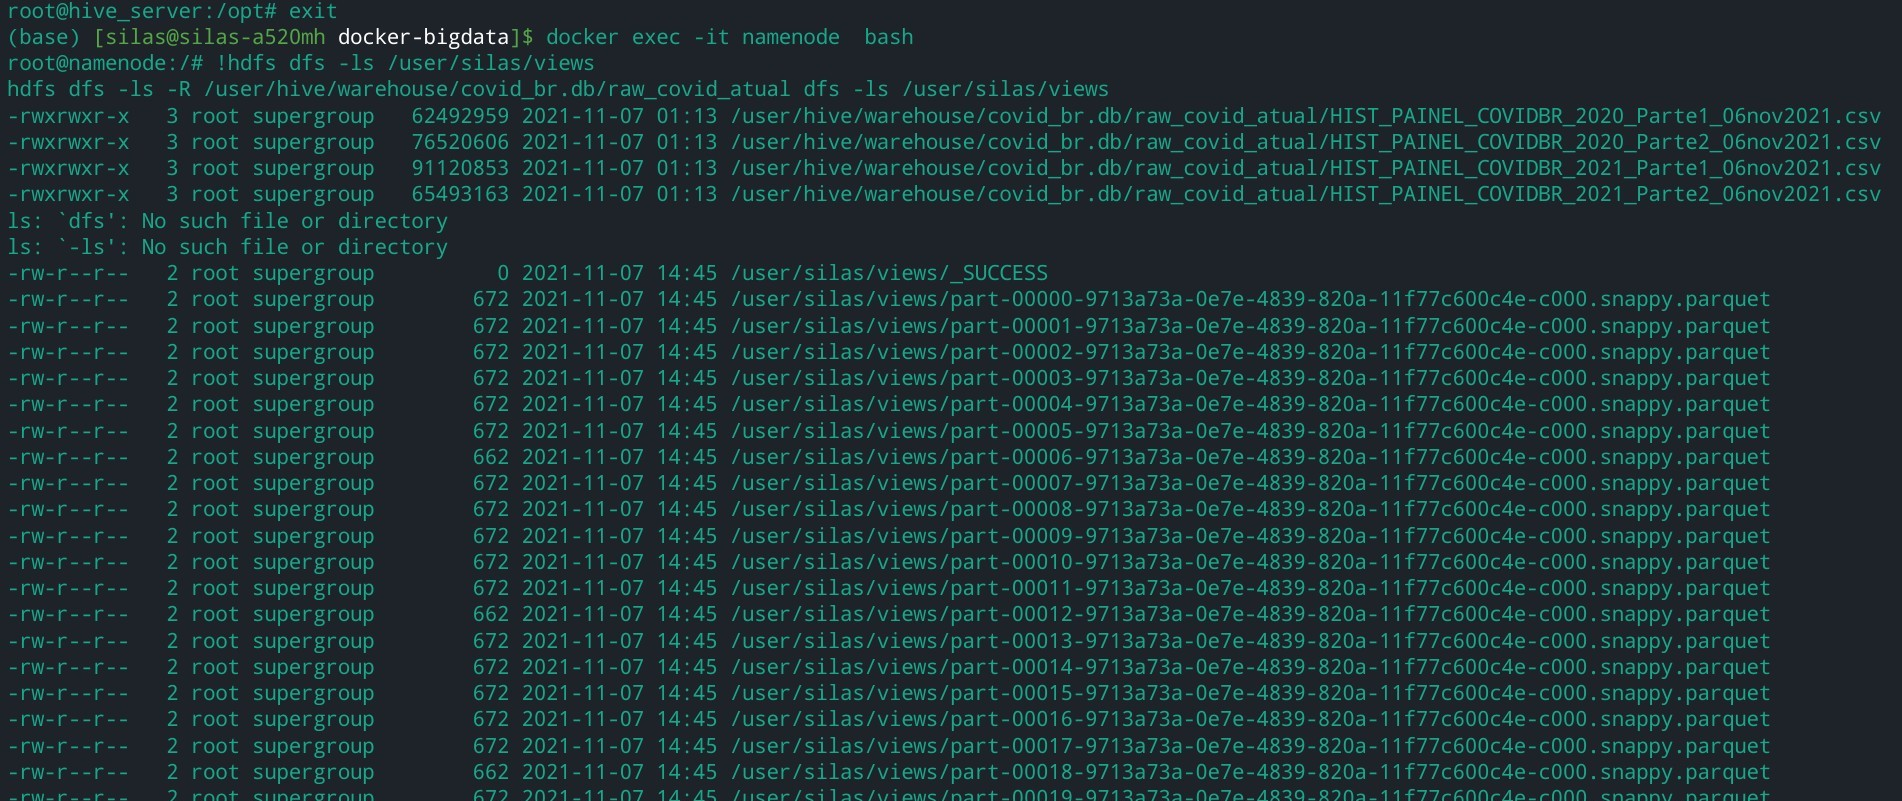

In [ ]:
# salvando a terceira visualização em tópico kafka batch
topic_covid_batch_output = view3\
.select(col("total_obitos").cast("string"),col("novos_obitos").cast("string"))\
.write\
.format("csv")\
.option("kafka.bootstrap.servers","kafka:9092")\
.option("topic","covidBr")\
.option("path","/user/silas/kafka/covidBr")\
.save()

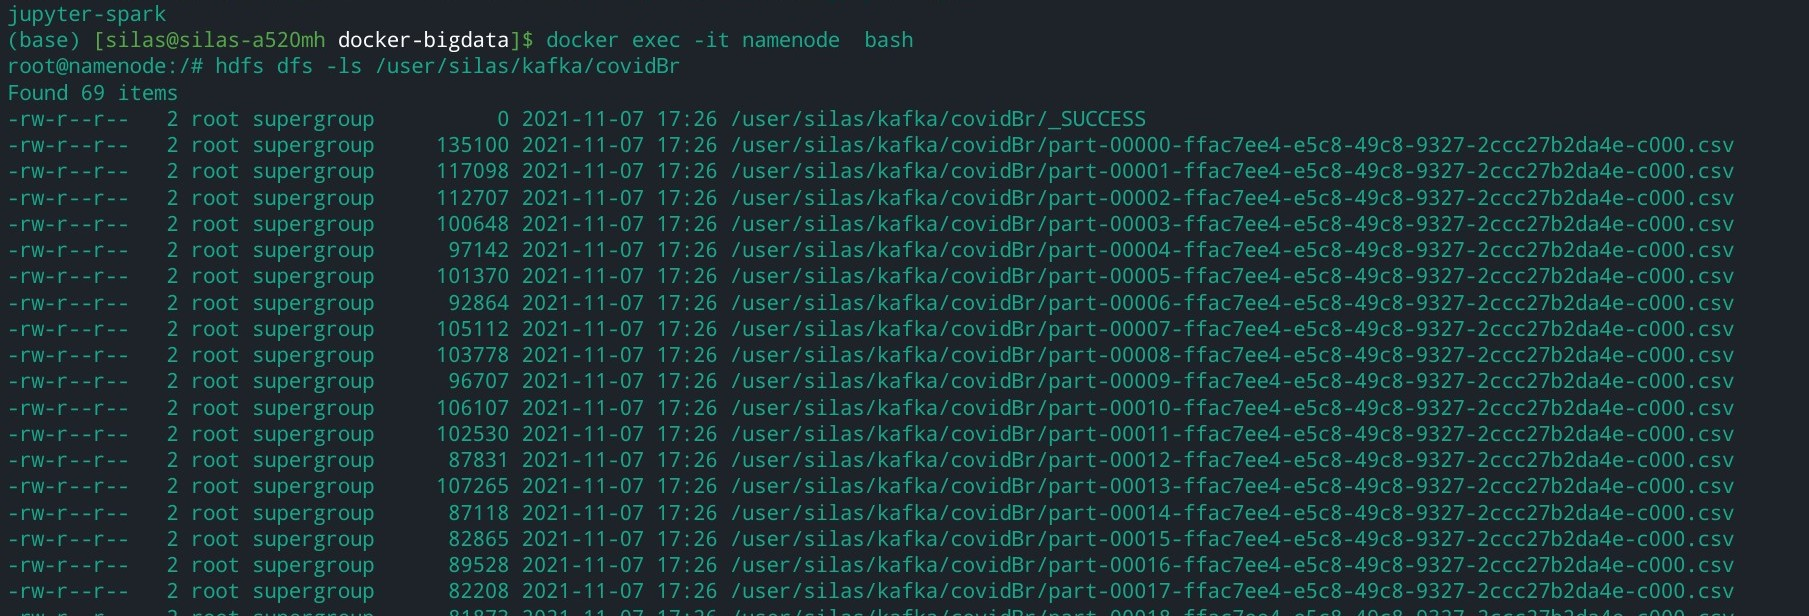

In [ ]:
#Salvando 3 view em CSV para posterior criação de dashboard
view3.coalesce(1).write.csv("/user/silas/views/csv1", header="true")

link dashboard exemplo:
https://datastudio.google.com/reporting/caa1b957-2c8c-40fe-aa73-f55f3f523f3c

**As atividades a seguir estão em produção**


In [ ]:
#saída para o elastic 2 para monitoramento busca e visão geral dos dados

In [15]:
df_relatorio = df\
.coalesce(4).write.format('json').save('/user/silas/output/relatorio_cv.json')


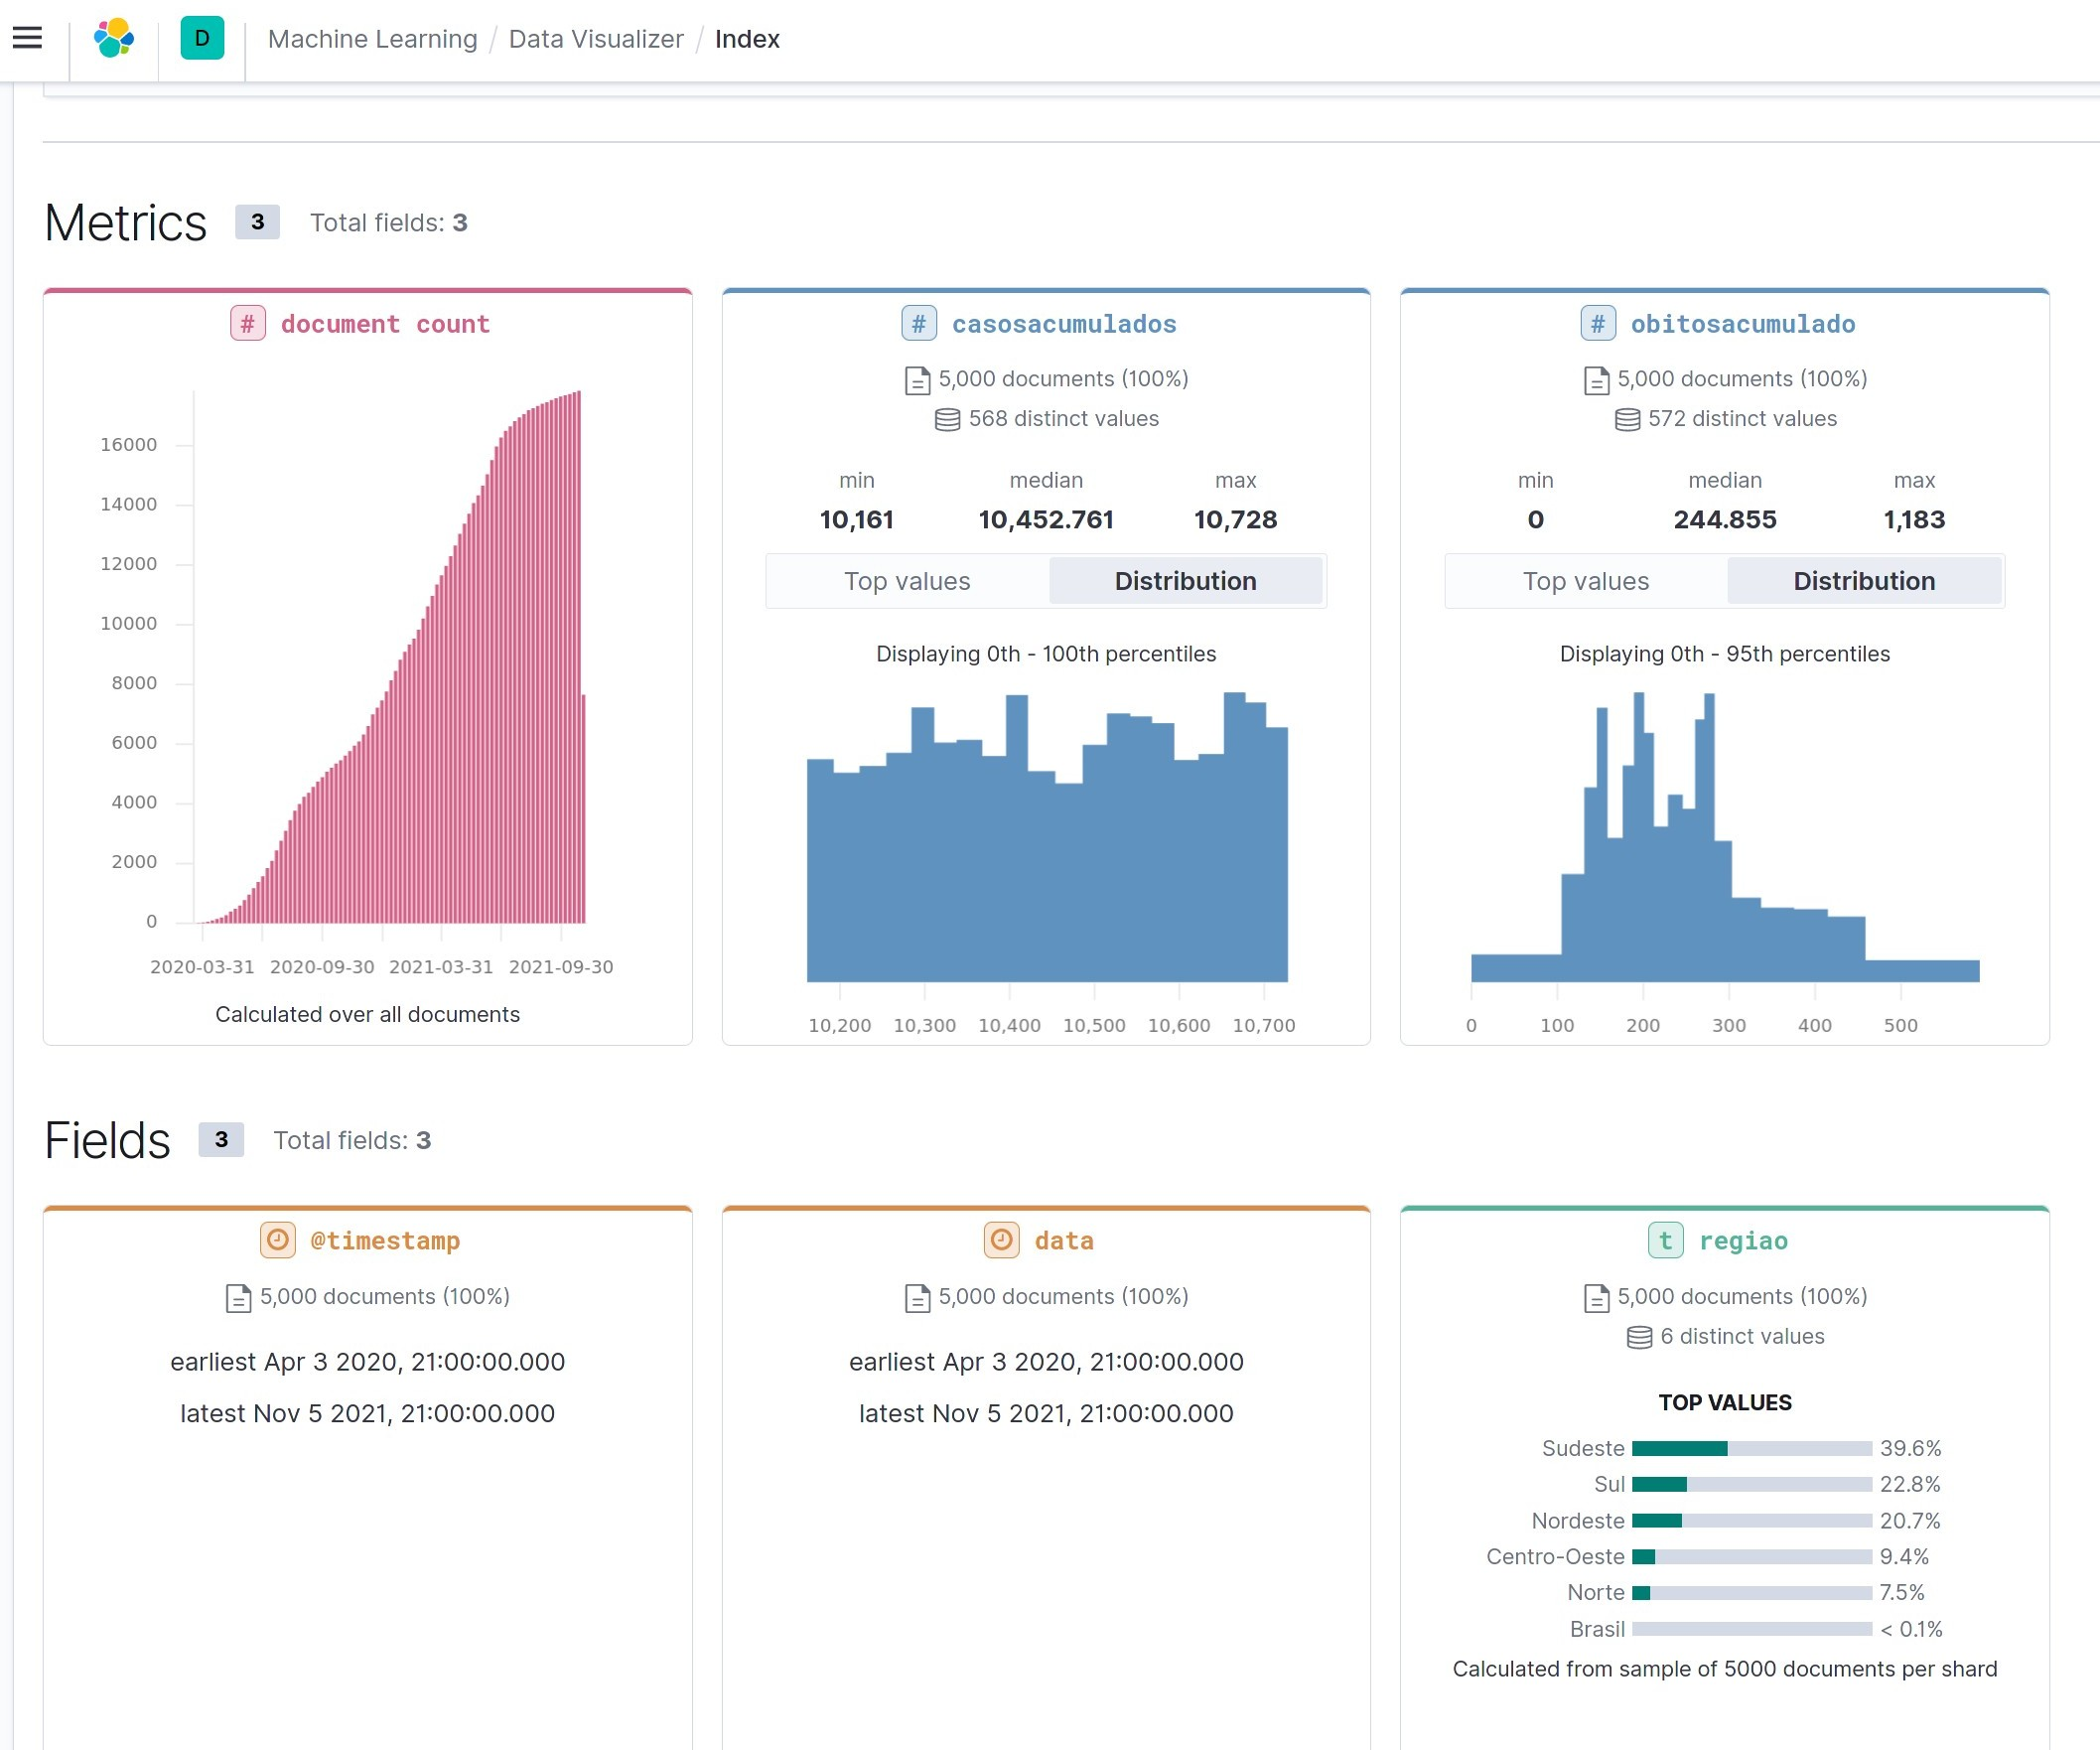